In [ ]:
# from here https://www.youtube.com/watch?v=VMj-3S1tku0
# thank you for your service karpathy ser 🫡🫡🫡🫡

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

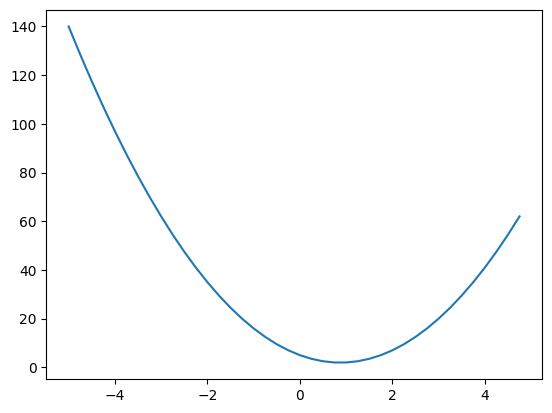

In [ ]:
xs = np.arange(-5, 5, 0.25) # a np.array [-5,5), with 0.25 between the els

# define some quadratic function
def f(x):
  return 4*x**2 - 7*x + 5

# make some ys
ys = f(xs) # wow numpy can do this so cool

# then plot it
plt.plot(xs, ys) # ok cool

# defining the value class, doing manual backprop, adding automatic backprop function

In [ ]:
# let's code a Value object
class Value():
  def __init__(self, data, _children=(), _op='', label=''): # this is to initialize, also called a constructor, the object with some initial attributes
    self.data = data
    self.grad = 0 # add a new attribute showing the grad of the end node with respect to this node
    self._prev = set(_children)
    self._backprop = lambda: None # an anonymous fuction that returns none, as the default value of our backprop function
    self._op = _op
    self.label = label

  def __repr__(self): # returns  a string representation of the object
    return f"Value(label='{self.label}', data={self.data},  grad={self.grad})"

  def __add__(self, other):
    # define the add method, so that Python could interpret what happens when two values get added together
    # when we use the operator +
    other = other if isinstance(other, Value) else Value(other)
    output = Value(self.data + other.data, (self, other), '+')

    # we also need to set up what happens to the output's children's backprop functions when they add together to the output
    def _backprop(): # impure function because this modifies state
      self.grad += 1 * output.grad # += because the grads stack together in the multivariate case (eg. when you have b = a + a; the grad is 2); see here https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/differentiating-vector-valued-functions/a/multivariable-chain-rule-simple-version
      other.grad += 1 * output.grad
    output._backprop = _backprop

    return output

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    # define the mul method, for the * operator
    other = other if isinstance(other, Value) else Value(other)
    output = Value(self.data * other.data, (self, other), '*')

    # set up the backprop function when __mul__ happens
    def _backprop():
      self.grad += other.data * output.grad # +=, same reasoning as for the add above
      other.grad += self.data * output.grad
    output._backprop = _backprop

    return output

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    # now for this implementation we'll only accept others that are float or ints
    assert isinstance(other, (int, float)), "only supports int or float powers/exponents for now"
    output = Value(self.data**other, (self, ), f'**{other}')

    def _backprop():
      self.grad += other * (self.data**(other-1)) * output.grad
    output._backprop = _backprop

    return output

  def __truediv__(self, other):
    return self * other**-1

  def __rtruediv__(self, other):
    return self**-1 * other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return (-self) + other

  def exp(self):
    # define exponentiation
    output = Value(math.exp(self.data), (self, ), 'exp')

    # set up the backprop function
    def _backprop():
      self.grad = output.data * output.grad
      # you shouldn't use += here; causes some bug where the backprop gets called before the output grad settles down to some value
      # the order of the topo sort is a bit random so you don't actually add the grads together, but you add an intermediate input which messes the calculation
      # self.grad += output.data * output.grad
    output._backprop = _backprop

    return output

  def tanh(self): # we can implement exponentiation and division methods here, but we're just going to use the math library
  # karpathy said that we could implement this however simple or complex or atomic we want; and the activation function could be simpler than this
  # what activation function simply does is *squashing* the input into some Range in the real numbers
    output = (math.exp(self.data*2) - 1) / (math.exp(self.data*2) + 1) # definition of tanh
    output = Value(output, (self, ), 'tanh') # wrap the output inside a Value object

    def _backprop():
      self.grad += (1 - output.data**2) * output.grad # should be +=; was = before because of bad topo_sort implementation
    output._backprop = _backprop

    return output

  def relu(self):
    # define a relu activation function
    output = Value(0 if self.data<0 else self.data, (self), 'relu')

    def _backprop():
      self.grad += (self.data>0) * output.grad # at 0 the grad is also 0, but why??
    output._backprop = _backprop

    return output

  def backprop(self):
    # first we need to turn the graph into a topo sort
    # sorta flatten it into a list that can be traversed serially
    topo = []
    seen = set()
    # this implementation of topo_sort is a bit wrong because it assumes that the root has not been visited yet
    # def topo_sort(root): # define some sort of a recursive function
    #   topo.append(root) # if we want to start at the root
    #   for n in root._prev:
    #     if n not in seen:
    #       seen.add(n)
    #       topo_sort(n)
    #     # topo.append(n) # if we want to start at the end

    # new implementation of the function topo_sort
    def topo_sort(n):
      if n not in seen:
        seen.add(n)
        for c in n._prev:
          topo_sort(c)
        topo.append(n) # this should be in the if block; so that you don't have nodes that's backpropped out of order
        # easiest example of this going awry if topo.append(n) is not inside the if block is this
        # say you have a node that goes like this (sorta like MLP)
        #     O
        # O <   > O
        #     O
        # imagine how this would go if topo.append(n) is outside of the if block
        # it would be appended twice !!

    topo_sort(self)

    # then do the backprop along the topo sort thing that we have
    for n in reversed(topo):
      n._backprop() # calls the backward function
      # print(n, n._backprop)

    return None # doesn't return anything
    # return topo

####
# __repr__
# Value(4) # try this out with the __repr__ method defined, and try it without the __repr__ method defined
# you can see every methods that an object has with the function dir(); so eg. dir(Value(4))

# __add__
# Value(2) + Value(3) # this works wow
# Value(2).__add__(Value(3)) # what actually happens here is this

# __mul__
# Value(2) * Value(3) # works
# Value(2).__mul__(Value(3)) # what actually happens

# __add__ and __mul__
# Value(2) * Value(3) + Value(4)
# Value(2).__mul__(Value(3)).__add__(Value(4)) # what actually happens

# children
# now say we have multiple chains of additions and multiplications
# and we want to know for each Value() node, what other nodes influence its value (or if its just some free-standing, independent node)
# to do this we add a new attribute of Value, called _prev, which is from the tuple _children,
# which lists down all the _children nodes that this node has.
# a = Value(2)
# b = Value(3)
# c = Value(4)
# d = a*b + c
# d._prev # the result would be {Value(data=4), Value(data=6)} because the multiplication is done first

# op
# we should also want to know what kind of operators produced some value
# a = Value(2)
# b = Value(3)
# c = Value(4)
# d = a*b + c
# d._op # will produce '+'

# labels
# we can also have labels to make this explicit
# this would help graphing the nodes later
# a = Value(2, label='a')
# b = Value(3, label='b')
# c = Value(4, label='c')
# d = a*b + c; d.label='d'

# Mock Series of Math Eqs (Not A Neural Net!!)
# now we make our own mock math eqs, with L as the end node
# remember that backprop is more general than neural nets; it just so happens that we can use backprop to optimize neural nets
# we can use backprop to optimize other math eqs
# a = Value(2, label='a')
# b = Value(3, label='b')
# c = Value(4, label='c')
# e = a*b; e.label='e'
# d = e + c; d.label='d'
# f = Value (7, label='f')
# L = d + f; L.label='L'

# adding it so that we can add a Value() object with an integer
# note that Value(2) + 1 works (because it actually calls Value(2).__add__(1))
# and 1 + Value(2) does not (because it actually calls 1.__add__(Value(2))),
# ints know nothing about Value objects, so they don't know how to add themselves with a Value object
# to solve this, we can define __rmull__ and __radd__ methods in Value
# so if python sees that it can't multiply one way; it will try to check if it can commutes the operation, then check if there's a __rmul__ (right mul) method defined
# that way, if there is, then python will call that
# 1 + Value(2)
# 1 * Value(2)

# we want to unpack the operations that result in tanh
# that means defining new methods in Value for exponentiation, division, substraction
# Value(2.0).exp() # exp works
# for division, we're going to implement a more general operation, ie. exponentiation/power but with the base being a Value object and the power/exponent being a float or integer
# Value(2.0) / Value(4.0) # works
# Value(2.0) / 4 # works
# 2 / Value(4.0) # works, with a rtruediv method
# Value(2) - Value(4) # works
# Value(2) - 4 # works
# 2 - Value(4) # works, with a rsub method

# testing the topo sort algo




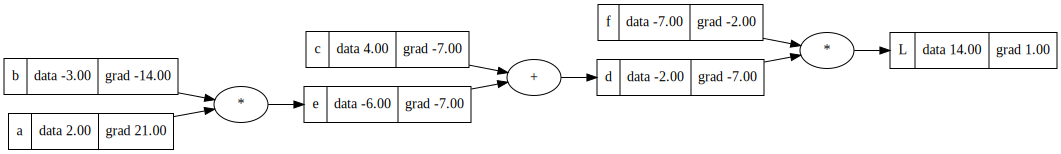

In [ ]:
# visualizing the nodes and edges, using graphviz's api
# graphviz is already installed, you can check using the command '''!pip show graphviz'''
from graphviz import Digraph
# Digraph means directed graph
# in graphviz, a dot can be either graph or digraph
# DOT is a graph description language, in graphviz

def trace(root):
  # builds a set of all nodes and edges in a graph (from karpathy)
  nodes, edges = set(), set()

  def build(v): # another helper function, i think karpathy is just lazy here lmao lfg (not lazy, he just wants to make a recursive function here)
    if v not in nodes: # if the vertex v is not in the set of nodes that we have, we add it into nodes
      nodes.add(v)
      for child in v._prev: # then for every child of the vertex v, make new edges that connec the vertex v with its children
        edges.add((child, v)) # add as tuples; with child in the left and v in the right
        build(child) # then do the same build for the child, recursive
        # if no child in v._prev, then this just gets skipped over
    # if v is in fact in nodes then just skip over

  build(root) # now start with roo
  return nodes, edges # return the nodes and edges that have been modified

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR means left-to-right

  nodes, edges = trace(root) # trace is a helper function, which builds a set of all nodes and a set of all edges
  for n in nodes: # iterate through every node in nodes
    # create a unique identifier of every node using the id() function,
    # make it a str so you can add them together with other uids (this will make sense lmao)
    uid = str(id(n))

    # then define a new node in dot
    # the label format seems to be old-style formatting (if we were to believe chatgpt lmao)
    # dot.node(name=uid, label="{data %.4f}" % (n.data,), shape='record') # old style is used maybe because we don't want to have double curly braces like we do have if we use the new format
    dot.node(name=uid, label='{{ {:s} | data {:.2f} | grad {:.2f} }}'.format(n.label, n.data, n.grad,), shape='record') # this is the new format, much better tbh
    # maybe explore what kinds of values are valid for the shape parameter for the node method here

    if n._op: # if the node n is a result of some operation, then we add a new node for this op
      dot.node(name=uid+n._op, label=n._op) # notice that for the name here we just add two strings together lmao
      # the default shape seems to be oval
      dot.edge(uid+n._op, uid) # then we make a new edge connecting the op with the parent node

  for n1, n2 in edges: # now we need to slightly modify the edges here
    dot.edge(str(id(n1)), str(id(n2))+n2._op) # ie. add the child node to the op node of its parent node

  return dot

# draw the svg
# draw_dot(L)

# defining the grads manually (lmao)
# here's our mock math eqs
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(4, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value (-7, label='f')
L = d * f; L.label='L'

# using chain rule we can find all the grads here
L.grad = 1
f.grad = -2
d.grad = -7
c.grad = -7
e.grad = -7
a.grad = 21
b.grad = -14

# now draw the dot
draw_dot(L)


In [ ]:
# trying out backprop by wiggling the independent vars
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(4, label='c')
f = Value (-7, label='f')

# grads
L.grad = 1
f.grad = -2
d.grad = -7
c.grad = -7
e.grad = -7
a.grad = 21
b.grad = -14

# 0.01 is the step size here; we MOVE the vars positively
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass
e = a*b; e.label='e'
d = e + c; d.label='d'
L = d * f; L.label='L'

print(L)

Value(label='L', data=21.125987999999996,  grad=0)


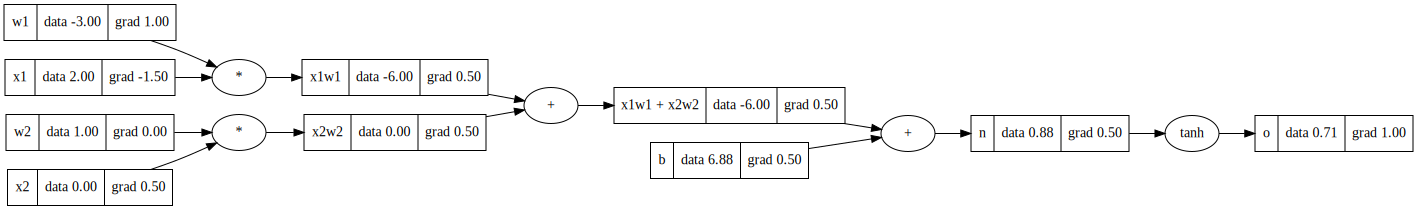

In [ ]:
# now we backprop a real neuron lfgg
# manual backprop mind you

# first define the neuron
# close to here https://www.mdpi.com/brainsci/brainsci-12-00863/article_deploy/html/images/brainsci-12-00863-g002.png
# the inputs (from other pre-neuron (?), from other neurons, or the dendrites)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# the weights (or the sensitivity of the synapses (dendrites?))
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# the bias of the neuron (the inherent trigger-happines of the neuron/cell body itself)
# b = Value(6.9, label='b')
b = Value(6.8814, label='b')

# now we add and multiply all of those together in the right order, results in the raw value before the activation function of the neuron
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o' # we'll need to implement this tanh method first in the class

# now we define the grads
o.grad = 1 # truism
n.grad = 1 - o.data**2 # d tanh(n) / dn = 1 - tanh^2(n)
b.grad = 1 * n.grad # + and chain rule
x1w1x2w2.grad = 1 * n.grad # + and chain rule
x2w2.grad = 1 * x1w1x2w2.grad
x1w1.grad = 1 * x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

# and draw it using graphviz
draw_dot(o)

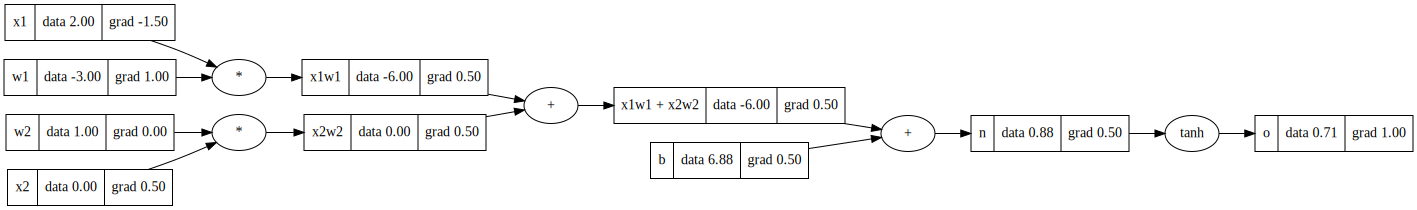

In [ ]:
# now we automate this backprop process
# we have to define a new attribute for this backprop process
# we've derived those for __add__, __mul__, and tanh() with unique _backprop functions defined for those operators
# and we can pass those functions to an attribute for the Value class, that can be called after the forward pass has been done
# so, let's define our neuron once again

# first define the neuron
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8814, label='b')

# ops
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o' # we'll need to implement this tanh method first in the class

# now we define the grads automatically this time (worked!! lfg)
# o.grad = 1
# o._backprop()
# n._backprop()
# b._backprop()
# x1w1x2w2._backprop()
# x1w1._backprop()
# x2w2._backprop()

# we can calculate the backpropped grads using a function that will just call them from the root to its children automatically
# defined as the backprop() method in the class Value
o.grad = 1
o.backprop()
# o._backprop()

# and draw it using graphviz
draw_dot(o)

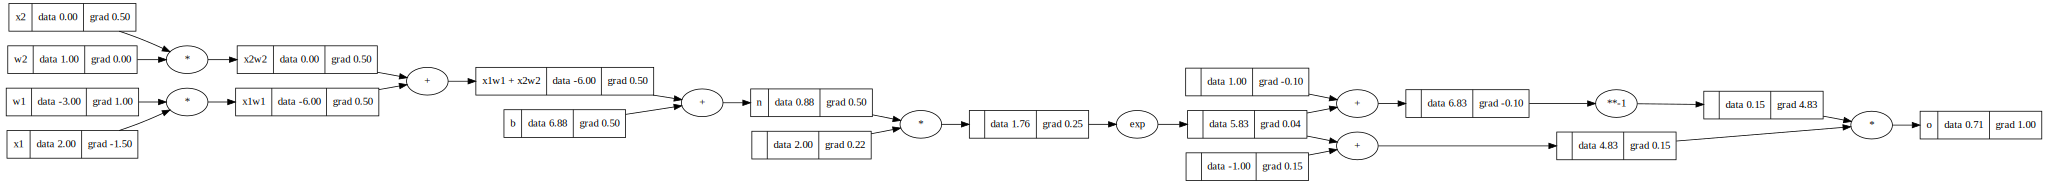

In [ ]:
# now we automate this backprop process
# we have to define a new attribute for this backprop process
# we've derived those for __add__, __mul__, and tanh() with unique _backprop functions defined for those operators
# and we can pass those functions to an attribute for the Value class, that can be called after the forward pass has been done
# so, let's define our neuron once again

# first define the neuron
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8814, label='b')

# ops
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
# o = n.tanh(); o.label='o' # we'll need to implement this tanh method first in the
### reimplementing tanh()
e = (n*2).exp()
o = (e-1) / (e+1)
### ---
o.label='o'

# now we define the grads automatically this time (worked!! lfg)
# o.grad = 1
# o._backprop()
# n._backprop()
# b._backprop()
# x1w1x2w2._backprop()
# x1w1._backprop()
# x2w2._backprop()

# we can calculate the backpropped grads using a function that will just call them from the root to its children automatically
# defined as the backprop() method in the class Value
o.grad = 1
o.backprop() # returns topo
# o._backprop()

# and draw it using graphviz
draw_dot(o)

# using torch as an example

In [ ]:
# now we're gonna use torch to do what micrograd is doing here
# micrograd largely conforms/is inspired by torch's api; so things will look similar here
import torch

In [ ]:
# first define the neuron
# also make sure that grad is enabled for leaf nodes
# because by default the grads for leaf nodes aren't calculated
# because most of them are usually inputs for training data; and you won't usually change them so the grads aren't informative

# inputs
x1 = torch.Tensor([2]).double();                x1.requires_grad_() # or we can set the attribute directly, x1.requires_grad = True
x2 = torch.Tensor([0]).double();                x2.requires_grad_()

# weights
w1 = torch.Tensor([-3]).double();               w1.requires_grad_()
w2 = torch.Tensor([1]).double();                w2.requires_grad_()

# bias
b = torch.Tensor([6.8813735870195432]).double();            b.requires_grad_()
# the number is from (1-arctanh((1-o)**0.5)) - x1*w1 - x2*w2
# the same with karpathy's lmao

# ops
n = x1*w1 + x2*w2 + b
o = n.tanh()

# backprop
o.backward()

# see if they are truly the same now with our micrograd implemetation
print(o.data.item())

print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# ok we have the same results with our Value implementation

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# making neuron, layer, mlp class

In [ ]:
import random # need this here

# make the Neuron class
class Neuron:
  def __init__(self, n_in: int) -> None:
    self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w*x + b
    activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    # print(activation)
    # print(wi * xi for wi, xi in zip(self.w, x))
    # print(list((w_.data, x_) for w_, x_ in zip(self.w, x)))
    output = activation.tanh()
    return output

  def parameters(self):
    return self.w + [self.b]

# make the Layer class (which is just a list of neurons)
class Layer:
  def __init__(self, n_in: int, n_out: int) -> None:
    self.neurons = [Neuron(n_in) for _ in range(n_out)]

  def __call__(self, x):
    output = [n(x) for n in self.neurons]
    return output[0] if len(output) == 1 else output

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

# make the MLP class (which is just a list of layers)
class MLP:
  def __init__(self, n_in: int, n_outs: list) -> None:
    size = [n_in] + n_outs
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(size)-1)] # karpathy uses range(len(n_outs)) here

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# trying out neuron
# n = Neuron(2)
# n([3, 2])
# draw_dot(n([3,2]))

# # trying out layer
# n = Layer(3, 4)
# n([1, 2, 3])
# draw_dot(n([3,2,4])[0])

# trying out mlp
# n = MLP(3, [4, 3, 2, 1])
# n = MLP(3, [4, 4, 1])
# input = [[random.uniform(-1, 1) for ]]
# n([1, 2, -1])
# draw_dot(n([1, 2, 0]))
# n.layers[0].neurons[0].w

## trying out loss function, manual gradient descent

In [ ]:
# trying out loss function
# first initialize our MLP
random.seed(42) # for good luck
n = MLP(3, [4, 4, 1])
# then we need to define our inputs and ground truth outputs
# in the next cell because we don't want to reinitialize n every time

In [ ]:
# inputs and outputs
xs = [[2, -3, 1],
      [1, 0, -1],
      [0.5, -0.25, -0.75],
      [1, 1.5, -0.8]]

ys = [1, 0, 0, 1]
ypred = [n(x) for x in xs]
# ypred

In [ ]:
# so the gradient descent should look like so
# forward pass
ypred = [n(x) for x in xs] # the forward pass
loss = sum((y_out-y_gt)**2 for y_out, y_gt in zip(ypred, ys)) # the loss calculation
loss

# you can also look at the params using the .parameters() method

Value(label='', data=1.715414087492978,  grad=0)

In [ ]:
# then the backward pass
loss.backprop()

In [ ]:
# then the update/step/descent
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
# trying out looping this grad descent process
random.seed(42) # for good luck
n = MLP(3, [4, 4, 1])

xs = [[2, -3, 1],
      [1, 0, -1],
      [0.5, -0.25, -0.75],
      [1, 1.5, -0.8]]

ys = [1, 0, 0, 1]
ypred = [n(x) for x in xs]

# while loss.data > 0.1:
#   ypred = [n(x) for x in xs]
#   loss = sum((y_out-y_gt)**2 for y_out, y_gt in zip(ypred, ys))
#   print(loss)
#   loss.backprop()
#   for p in n.parameters():
#     p.data += -1e-8 * p.grad # this always explodes to 10, no matter how small the step size is lmao what's going on

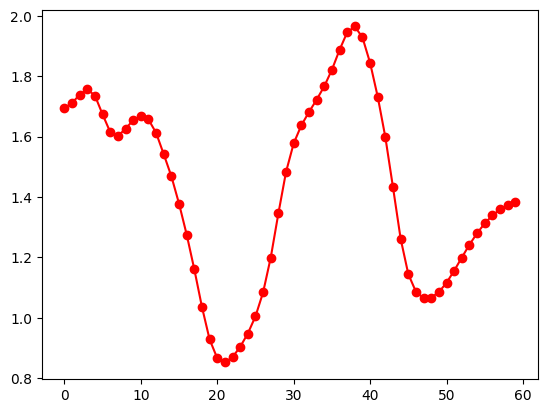

In [ ]:
random.seed(42) # for good luck
n = MLP(3, [4, 4, 100, 100, 10, 4, 1])

xs = [[2, -3, 1],
      [1, 0, -1],
      [0.5, 1, -0.75],
      [1, 0.2, -0.8]]

ys = [1, 0, 0, 1]
ypred = [n(x) for x in xs]

x_data = list(range(100)) # the range
loss_data = []

for i in enumerate(x_data):
  ypred = [n(x) for x in xs] # forward pass
  loss = sum((y_out-y_gt)**2 for y_out, y_gt in zip(ypred, ys)) # loss calc
  # print(loss)
  loss_data.append(loss.data) # loss_data apend
  # backward pass needs to reset the grads to 0
  for p in n.parameters():
    p.grad = 0 # flushing the grad here
  loss.backprop() # backward pass
  for p in n.parameters():
    p.data += -1e-3 * p.grad

plt.plot(x_data, loss_data, 'ro-')

### plotting the loss using matplotlib's FuncAnimation

In [ ]:
## this takes so long

# # trying to plot the loss real time
# # using matplotlib's animation
# from matplotlib.animation import FuncAnimation

# loss_data = [] # y


# fig, ax = plt.subplots()
# x_data, loss_data = [], [] # loss_data is y_data
# ln, = plt.plot([], [], 'ro-') # you can use the third parameter to specify how your plot would look like, eg. 'ro' means red with circle mark (lmao)
# # plt.plot() returns a list of line; we use ln, to take the first el of that list (of only length one)
# # so that we can dynamically update this Line2D object

# # define the MLP boiler plate
# random.seed(42) # for good luck
# n = MLP(3, [4, 4, 10, 20, 20, 20, 10, 4, 1])

# xs = [[2, -3, 1],
#       [1, 0, -1],
#       [0.5, -0.25, -0.75],
#       [1, 1.5, -0.8]]

# ys = [1, 0, 0, 1]
# # ypred = [n(x) for x in xs]
# # ---

# def init(): # init func for FuncAnimation
#   ax.set_xlim(100) # 1000 frames
#   ax.set_ylim(0, 11)
#   return ln,

# def update(frame): # the func that updates the line frame per frame
#   global ypred, n, loss, x_data, loss_data # this is p genius tbh?? but makes the function not a pure function
#   ypred = [n(x) for x in xs]
#   loss = sum((y_out-y_gt)**2 for y_out, y_gt in zip(ypred, ys))
#   loss_data.append(loss.data)
#   x_data.append(frame)
#   # print(loss_data)

#   # then we update the loss
#   loss.backprop()
#   for p in n.parameters():
#     p.data += -1e-4 * p.grad # 0.01 is the step size

#   # then we update the line data
#   ln.set_data(x_data, loss_data)
#   return ln,

# # create the animation
# ani = FuncAnimation(fig, update, frames=range(100), init_func=init, blit=True)

# # show the plot
# # plt.show() # animation doesn't work on colab lmao

# # save it as mp4
# # Save the animation
# ani.save('/content/loss_animation.mp4', writer='ffmpeg', fps=30)

# # Display the video
# from IPython.display import Video
# Video('/content/loss_animation.mp4')


In [ ]:
# # for i in range(100):
# #   update(i)
# print(loss_data)

### coretan lmao

In [ ]:
# loss function
# this works wow
loss = sum((yout-ygt)**2 for yout, ygt in zip(ypred,ys))
# loss
# draw_dot(loss) # huge

In [ ]:
# start of loop of gradient descent
loss.backprop() # to know the grads (only do this once per step of gradient descent!!) (doing it twice eg just means you're doubling your step size)

In [ ]:
# then we look for params here
n.layers[0].neurons[0].parameters()
# n.parameters()
# len(n.parameters())

In [ ]:
# old loss
loss = sum((yout-ygt)**2 for yout, ygt in zip(ypred,ys))
loss

In [ ]:
# now we're doing gradient descent manually here
# the params grad descent part; -0.01 because we want to /lower/ the loss function
# first find the grads
# loss.backprop() # you should only do the backprop once lmao (it adds up)
# now the loop
for p in n.parameters():
  p.data += -0.01 * p.grad

In [ ]:
# new sample params
n.layers[0].neurons[0].parameters()

In [ ]:
# new loss
ypred = [n(x) for x in xs] # forward pass
loss = sum((yout-ygt)**2 for yout, ygt in zip(ypred,ys))
loss # lower loss lfg
# then we calculate the backprop all over again